<a href="https://colab.research.google.com/github/rajdeepd/tensorflow_2.0_book_code/blob/master/ch08/alpine_samples/GAN_alpine_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demistifying GANs in TensorFlow 2.0

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

In [ ]:
print(tf.__version__)

2.3.0


## Global Parameters

In [ ]:
BATCH_SIZE = 10

In [ ]:
BUFFER_SIZE = 60000

In [ ]:
EPOCHES = 300

In [ ]:
OUTPUT_DIR = "img_alpine" # The output directory where the images of the generator a stored during training

## Loading the Alpine dataset

In [ ]:
#(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
from load_dataset import get_alpine_dataset

data_dir = '/Users/rdua/Downloads/alpine/alpine/'
batch_size = 33
img_height = 302
img_width = 403

#train_ds_1 = get_alpine_dataset(data_dir, batch_size, img_height, img_width)
import numpy as np
from PIL import Image

import os
filelist = os.listdir(data_dir)
print(filelist)

x = np.array([np.array(Image.open(data_dir  + fname)) for fname in filelist])
train_ds_1 = []
for x1 in x:
    train_ds_1.append(x1.reshape(4032,9072))

['20171030_134121.jpg', '20171030_135012.jpg', '20171030_134907.jpg', '20171030_135428.jpg', '20171030_133845.jpg', '20171030_135856.jpg', '20171030_134035.jpg', '20171030_134141.jpg', '20171030_134949.jpg', '20171030_135110.jpg', '20171030_134025.jpg', '20171030_135850.jpg', '20171030_135139.jpg', '20171030_134153.jpg', '20171030_135728.jpg', '20171030_134026.jpg', '20171030_134956.jpg', '20171030_135042.jpg', '20171030_135136.jpg', '20171030_135125.jpg', '20171030_135118.jpg', '20171030_135127.jpg', '20171030_133928.jpg', '20171030_134920.jpg', '20171030_133915.jpg', '20171030_134936.jpg', '20171030_134857.jpg', '20171030_135153.jpg', '20171030_133911.jpg', '20171030_134918.jpg', '20171030_134105.jpg', '20171030_135031.jpg', '20171030_135019.jpg']


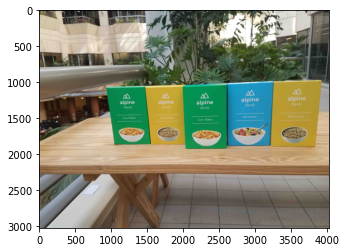

In [ ]:
plt.imshow(x[1])

In [ ]:
#151 width, 201 height
import numpy as np
y1 = []
for f in filelist:
    full_f = data_dir + "/" + f
    img = Image.open(full_f)
    half = 0.05
    out = img.resize( [int(half * s) for s in img.size] )
    #out.shape (201, 151)
    out1 = np.asarray(out).reshape(201,453).reshape(1,91053)
    y1.append(out1)
#y1


In [ ]:
y2 = np.asarray(y1)
y2.shape

(33, 1, 91053)

### Adding the Data to tf.Dataset

In [ ]:
#train_images = train_images.astype("float32")
#train_images = (train_images - 127.5) / 127.5

In [ ]:
#train_dataset = tf.data.Dataset.from_tensor_slices(train_images.reshape(train_images.shape[0],784)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
train_dataset = y2

## Generator Network

In [ ]:
class Generator(keras.Model):
    
    def __init__(self, random_noise_size = 10000):
        super().__init__(name='generator')
        #layers
        self.input_layer = keras.layers.Dense(units = random_noise_size)
        self.dense_1 = keras.layers.Dense(units = 22763)
        self.leaky_1 =  keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_2 = keras.layers.Dense(units = 22765)
        self.leaky_2 = keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_3 = keras.layers.Dense(units = 45526)
        self.leaky_3 = keras.layers.LeakyReLU(alpha = 0.01)
        self.output_layer = keras.layers.Dense(units=91053, activation = "tanh")
        
    def call(self, input_tensor):
        ## Definition of Forward Pass
        x = self.input_layer(input_tensor)
        x = self.dense_1(x)
        x = self.leaky_1(x)
        x = self.dense_2(x)
        x = self.leaky_2(x)
        x = self.dense_3(x)
        x = self.leaky_3(x)
        return  self.output_layer(x)
    
    def generate_noise(self,batch_size, random_noise_size):
        return np.random.uniform(-1,1, size = (batch_size, random_noise_size))

### Objective Function

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
def generator_objective(dx_of_gx):
    # Labels are true here because generator thinks he produces real images. 
    return cross_entropy(tf.ones_like(dx_of_gx), dx_of_gx) 

### Plotting The Noise (Fake Image)

In [1]:
generator = Generator()

NameError: ignored

In [2]:
fake_image = generator(np.random.uniform(-1,1, size =(1,91053)))

NameError: ignored

In [ ]:
fake_image.shape

In [ ]:
fake_image = tf.reshape(fake_image, shape = (201,453))

In [ ]:
plt.imshow(fake_image, interpolation='nearest')

## Discriminator Network

In [ ]:
class Discriminator(keras.Model):
    def __init__(self):
        super().__init__(name = "discriminator")
        
        #Layers
        self.input_layer = keras.layers.Dense(units = 91053)
        self.dense_1 = keras.layers.Dense(units = 45526)
        self.leaky_1 =  keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_2 = keras.layers.Dense(units = 22763)
        self.leaky_2 = keras.layers.LeakyReLU(alpha = 0.01)
        self.dense_3 = keras.layers.Dense(units = 11000)
        self.leaky_3 = keras.layers.LeakyReLU(alpha = 0.01)
        
        self.logits = keras.layers.Dense(units = 1)  # This neuron tells us if the input is fake or real
    def call(self, input_tensor):
          ## Definition of Forward Pass
        x = self.input_layer(input_tensor)
        x = self.dense_1(x)
        x = self.leaky_1(x)
        x = self.leaky_2(x)
        x = self.leaky_3(x)
        x = self.leaky_3(x)
        x = self.logits(x)
        return x

In [ ]:
discriminator = Discriminator()

### Objective Function

In [ ]:
def discriminator_objective(d_x, g_z, smoothing_factor = 0.9):
    """
    d_x = real output
    g_z = fake output
    """
    real_loss = cross_entropy(tf.ones_like(d_x) * smoothing_factor, d_x) # If we feed the discriminator with real images, we assume they all are the right pictures --> Because of that label == 1
    fake_loss = cross_entropy(tf.zeros_like(g_z), g_z) # Each noise we feed in are fakes image --> Because of that labels are 0
    
    total_loss = real_loss + fake_loss
    
    return total_loss

## Optimizer

In [ ]:
generator_optimizer = keras.optimizers.RMSprop()
discriminator_optimizer = keras.optimizers.RMSprop()

## Training Functions

In [ ]:
@tf.function()
def training_step(generator: Discriminator, discriminator: Discriminator, images:np.ndarray , k:int =1, batch_size = 1):
    for _ in range(k):
         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            noise = generator.generate_noise(batch_size, 91053)
            g_z = generator(noise)
            d_x_true = discriminator(images) # Trainable?
            d_x_fake = discriminator(g_z) # dx_of_gx

            discriminator_loss = discriminator_objective(d_x_true, d_x_fake)
            # Adjusting Gradient of Discriminator
            gradients_of_discriminator = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # Takes a list of gradient and variables pairs
            
              
            generator_loss = generator_objective(d_x_fake)
            # Adjusting Gradient of Generator
            gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) 
    

In [ ]:
seed = np.random.uniform(-1,1, size = (1, 91053)) # generating some noise for the training

In [ ]:
# Just to make sure the output directory exists..
import os
directory=OUTPUT_DIR
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
for batch in train_dataset: 
    print(batch.shape)

(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)
(1, 91053)


In [ ]:
def training(dataset, epoches):
    for epoch in range(epoches):
        for batch in dataset: 
            #print(batch[0])
            #for b in batch:
            #    print(b)
            training_step(generator, discriminator, batch ,
                          batch_size = BATCH_SIZE, k = 1)
            
        ## After ith epoch plot image 
        if (epoch % 5) == 0: 
            fake_image = tf.reshape(generator(seed), shape = (201,151, 3))
            print("{}/{} epoches".format(epoch, epoches))
            #plt.imshow(fake_image, cmap = "gray")
            plt.imsave("{}/{}.png".format(OUTPUT_DIR,epoch),fake_image)

In [ ]:
%%time
#training(train_dataset, EPOCHES)
training(train_dataset, EPOCHES)

## Testing the Generator

In [ ]:
fake_image = generator(np.random.uniform(-1,1, size = (1, 100)))
plt.imshow(tf.reshape(fake_image, shape = (28,28)), cmap="gray")

plt.imsave("article/0.png",tf.reshape(fake_image, shape = (28,28)), cmap="gray")

## Obsolete Training Function

I tried to implement the training step with the k factor as described in the original paper. I achieved much worse results as with the function above. Maybe i did something wrong?!


@tf.function()
def training_step(generator: Discriminator, discriminator: Discriminator, images:np.ndarray , k:int =1, batch_size = 256):
    for _ in range(k):
        with tf.GradientTape() as disc_tape:
            noise = generator.generate_noise(batch_size, 100)
            g_z = generator(noise)
            d_x_true = discriminator(images) # Trainable?
            d_x_fake = discriminator(g_z) # dx_of_gx

            discriminator_loss = discriminator_objective(d_x_true, d_x_fake, smoothing_factor=0.9)
            # Adjusting Gradient of Discriminator
            gradients_of_discriminator = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # Takes a list of gradient and variables pairs
    
    with tf.GradientTape() as gen_tape:
        noise = generator.generate_noise(batch_size, 100)
        d_x_fake = discriminator(generator(noise))
        generator_loss = generator_objective(d_x_fake)
        # Adjusting Gradient of Generator
        gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) 